## Initial settings

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{7}"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
import tools as t
import joblib

from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow import keras
import tensorflow as tf

2024-01-09 20:01:46.874770: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
root_path = "/home/dg321/gitTest/PRI/irp/Ventilation/AAE4Ventilation"

## Load processed data

In [6]:
X_train_loaded = np.load(root_path + '/data/X_train_1124.npy')   # data before standardization
all_values = np.load(root_path + '/data/all_values_1124.npy')  # data after standardization
print(X_train_loaded.shape)
print(all_values.shape)

(36316, 56)
(36316, 56)


In [7]:
fields_list = ['time_sin', 'time_cos', 'Occupancy', 'door_gap', 'window_gap', 'humidity', 'VOC_ppb', 'temperature_Main', 'temperature_BRT', 'temperature_BRM', 'temperature_BRB', 'temperature_BMT', 'temperature_BMM', 'temperature_BLT', 'temperature_BLB', 'temperature_WRB', 'temperature_WMB', 'temperature_WLB', 'temperature_WLF', 'temperature_DoorRT', 'temperature_BTable', 'temperature_PRUR', 'temperature_PRUL', 'temperature_PRDR', 'temperature_PRDL', 'temperature_PLDR', 'temperature_Out', 'light_BRT', 'light_BRM', 'light_BRB', 'light_BMT', 'light_BMM', 'light_BLT', 'light_BLB', 'light_WRB', 'light_WMB', 'light_WLB', 'light_WLF', 'light_DoorRT', 'light_BTable', 'light_PRUR', 'light_PRUL', 'light_PRDR', 'light_PRDL', 'light_PLDR', 'light_Out', 'outdoor_temperature', 'outdoor_humidity', 'outdoor_windgust', 'outdoor_windspeed', 'outdoor_winddir', 'outdoor_sealevelpressure', 'outdoor_dew', 'outdoor_cloudcover', 'outdoor_solarradiation', 'outdoor_solarenergy']

In [8]:
ncoeffs = X_train_loaded.shape[1]
print(ncoeffs)
ntimes = 32
BATCH_SIZE = 32
step = 1

56


In [9]:
print("Snapshot Matrix shape", all_values.shape)

Snapshot Matrix shape (36316, 56)


In [10]:
data_ct = t.concat_timesteps(all_values[10000:16000], ntimes, step)

In [11]:
train_ct, test_ct = t.train_test_split(data_ct, testFrac=0.2)

Training samples = 4747 Testing samples = 1221


In [12]:
# create dataset
train_dataset, X_train_4d = t.create_dataset(train_ct, ncoeffs, ntimes, BATCH_SIZE)

2024-01-09 20:03:12.454306: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-09 20:03:13.314472: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6691 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:db:00.0, compute capability: 7.5


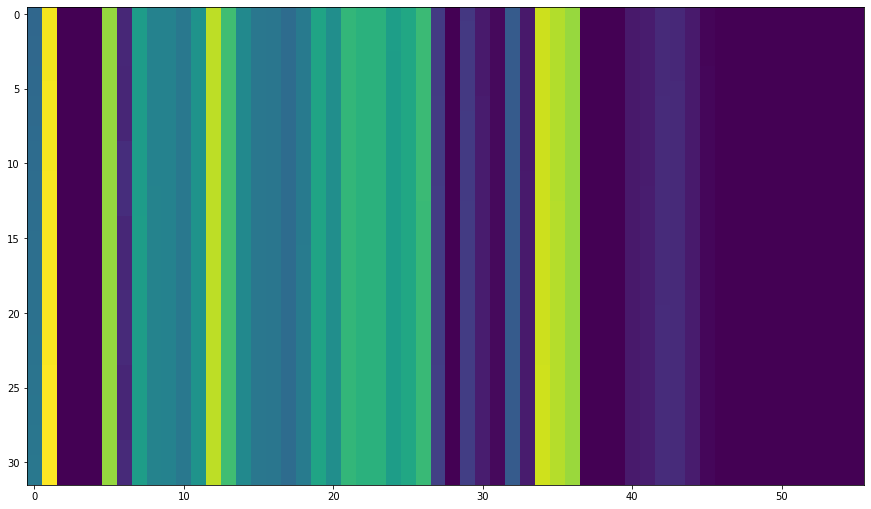

In [11]:
plt.figure(figsize=(15,25))
plt.imshow(X_train_4d[0,:,:,0])

## Build network and Load trained model

In [13]:
latent_dim = 50

In [14]:
def make_encoder_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Conv2D(128, (3, 3), strides=(1, 1), padding='same', input_shape=[ntimes, ncoeffs, 1]))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(64, (3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.LeakyReLU())
    model.add(keras.layers.Dropout(0.2))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(latent_dim))
    return model

def make_decoder_model():
  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(ntimes*ncoeffs*32, use_bias=False, activation='relu', input_shape=(latent_dim,)))
  model.add(keras.layers.Reshape((ntimes, ncoeffs, 32)))

  model.add(keras.layers.Conv2DTranspose(64, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same', use_bias=False))
  model.add(keras.layers.BatchNormalization())
  model.add(keras.layers.LeakyReLU())

  model.add(keras.layers.Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', output_padding=[0,0], use_bias=False, activation='sigmoid'))

  return model

def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(keras.layers.Dense(240, activation="relu", input_shape=(latent_dim,)))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(120, activation="relu"))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(60, activation="relu"))
    model.add(keras.layers.Dropout(rate=0.2))
    model.add(keras.layers.Dense(1))
    return model

In [15]:
encoder = make_encoder_model()
decoder = make_decoder_model()
discriminator = make_discriminator_model()

autoencoder = keras.models.Sequential([encoder, decoder])
enc_disc = keras.models.Sequential([encoder, discriminator])

# load the model
case = 'all'
epochs = 6000
latent_dim = 50
step = 1
ntimes = 32
autoencoder = load_model(root_path + '/models/1124_aae_ae_n{}_e{}_s{}_l{}.h5'.format(ntimes, epochs, step, latent_dim), compile=False)

encoder, decoder = load_model(root_path + '/models/1124_aae_enc_disc_n{}_e{}_s{}_l{}.h5'.format(ntimes, epochs, step, latent_dim), compile=False).layers

## Predicting

In [56]:
codings_size = all_values.shape[1]

In [57]:
data_ct_test = t.concat_timesteps(all_values[16000:18000], ntimes, step)
test_ct, _ = t.train_test_split(data_ct_test, testFrac=0.0)
# create dataset
test_dataset, X_test_4d = t.create_dataset(test_ct, ncoeffs, ntimes, BATCH_SIZE)

Training samples = 1968 Testing samples = 0


In [58]:
mse = tf.keras.losses.MeanSquaredError()
def mse_loss(inp, outp):
    
    inp = tf.reshape(inp, [-1, codings_size])
    outp = tf.reshape(outp, [-1, codings_size])
    return mse(inp, outp)

In [59]:
X_test_for_conv = X_test_4d
num_coeffs = 56
input_timestamps = 32
prediction_num = 200
# tqdm
n_pred = prediction_num

### Start from time level 0

In [34]:
scaler = 1

def predict_coding1(initial_pred, real_coding):
    initial_pred = initial_pred.copy()
    loss = []
    for epoch in range(20):
        decoder_output = autoencoder.predict(initial_pred)
        loss.append(mse_loss(real_coding, decoder_output[:,:(ntimes - 1),:,:]).numpy())
        # print(loss[-1])
        initial_pred[:,(ntimes - 1):,:,:] = decoder_output[:,(ntimes - 1):,:,:]

    return decoder_output,loss

In [35]:
# Start from time level 0
prediction_num = 200
n = 0

real_value = X_test_for_conv[n].reshape(1,-1)

# Extract value of 0-(m-2) time levels as real value

real_value = real_value[:,:num_coeffs*(input_timestamps - 1)]

real_value = real_value.reshape((1, input_timestamps-1, X_test_for_conv.shape[2], 1))

# Set value of time level m-1 as same as that of time level m-2

initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)



# Predict a point forward in time (time level m-1)

prediction_values,loss = predict_coding1(initial_pred, real_value)
# print(prediction_values.shape)


# Update real value and initial guess
X_predict = []
X_predict.append(prediction_values)
# print(prediction_values.reshape(-1,num_coeffs).shape)

# prediction of time level m-1

gen_predict = prediction_values[:,(input_timestamps - 1):,:,:]

# Add the predicted value to the real value (time levels 1-(m-1))

real_value = np.concatenate((real_value[:,1:,:,:], gen_predict), axis=1)

# Set value of time level m as same as that of time level m-1

initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)



# Predict 10 points forward in time

for i in range(prediction_num-1):

    prediction_values,loss = predict_coding1(initial_pred, real_value)

    # Update real value and initial guess

    gen_predict = prediction_values[:,(input_timestamps - 1):,:,:]
    print(gen_predict.shape)

    X_predict.append(gen_predict)

    real_value = np.concatenate((real_value[:,1:,:,:], gen_predict), axis=1)

    initial_pred = np.concatenate((real_value, real_value[:,-1:,:,:]), axis=1)

X_predict = np.concatenate(X_predict, axis = 1)
print(X_predict.shape)

1/1 [==============================] - 0s 19ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 24ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 23ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 21ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 22ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 56, 1)
1/1 [==============================] - 0s 20ms/step
(1, 1, 56, 1)
1/1 [=====

In [36]:
X_predict = X_predict.reshape(-1, ncoeffs)
print(X_predict.shape)

(231, 56)


In [37]:
# np.save(root_path + '/data/all_values.npy', all_values)
np.save(root_path + '/predictions/X_predict_1208_test_num{}.npy'.format(prediction_num), X_predict)

### Scale back & Visualisation

In [38]:
X_predict = np.load(root_path + '/predictions/X_predict_1208_test_num{}.npy'.format(prediction_num))

In [39]:
print(X_predict.shape)

(231, 56)


(array([6744.,  166.,  839.,  616., 1421., 1455.,  878.,  252.,  328.,
         237.]),
 array([6.2938222e-16, 9.9114671e-02, 1.9822934e-01, 2.9734403e-01,
        3.9645869e-01, 4.9557337e-01, 5.9468806e-01, 6.9380271e-01,
        7.9291737e-01, 8.9203209e-01, 9.9114674e-01], dtype=float32),
 <BarContainer object of 10 artists>)

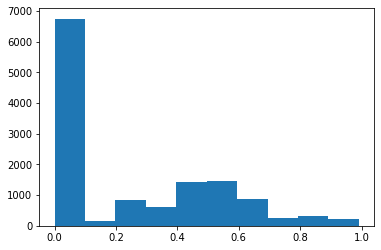

In [40]:
plt.hist(X_predict.flatten())

In [42]:
# change the output file name
fields_scaledback = []
for i in range(0,X_predict.shape[1]):
    # scaler = MinMaxScaler((0, 1))
    # scaler.fit(fields[fields_list[i]].values.reshape(-1,1))
    scaler = joblib.load(root_path + '/scalers/1124_train_scaler01_{}.pkl'.format(fields_list[i]))
    field_scaledback = scaler.inverse_transform(X_predict[:,i].reshape(-1, 1))
    print(field_scaledback.shape)
    fields_scaledback.append(field_scaledback)

X_predict_scaledback = np.hstack(fields_scaledback)

(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)
(231, 1)


In [44]:
X_test = X_train_loaded[16000:18000]
all_values_scaledback = X_test

(2000, 56)


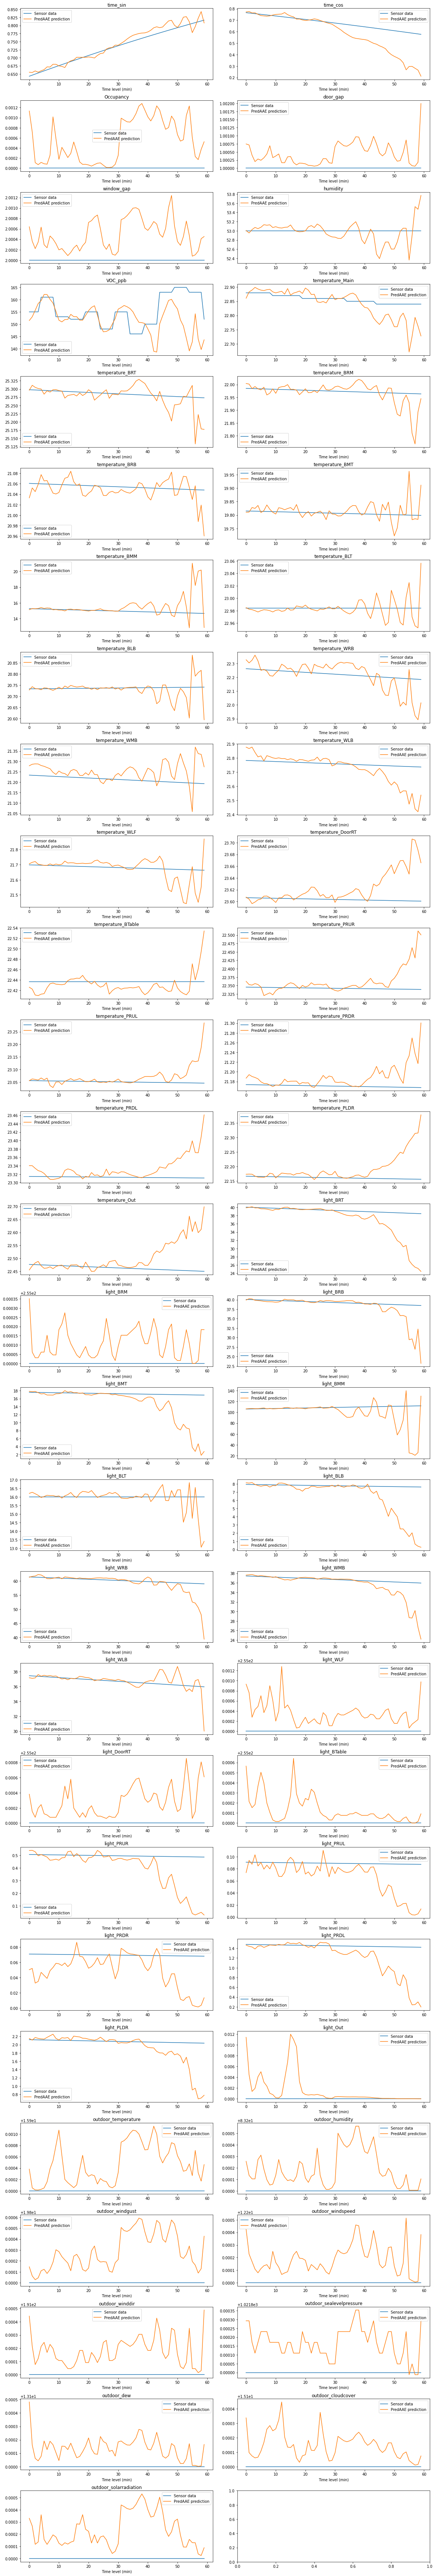

In [47]:
## show the first 60 time steps
fig, ax = plt.subplots(28,2, figsize=[16,24*4])  # figsize=[16,8]
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(55):
    ax.flatten()[i].plot(range(0,60), all_values_scaledback[:60,i], '-')
    ax.flatten()[i].plot(range(0, 60), X_predict_scaledback [:60,i], '-')
    ax.flatten()[i].legend(['Sensor data', 'PredAAE prediction'])
    ax.flatten()[i].set_title(fields_list[i])
    ax.flatten()[i].set_xlabel('Time level (min)')

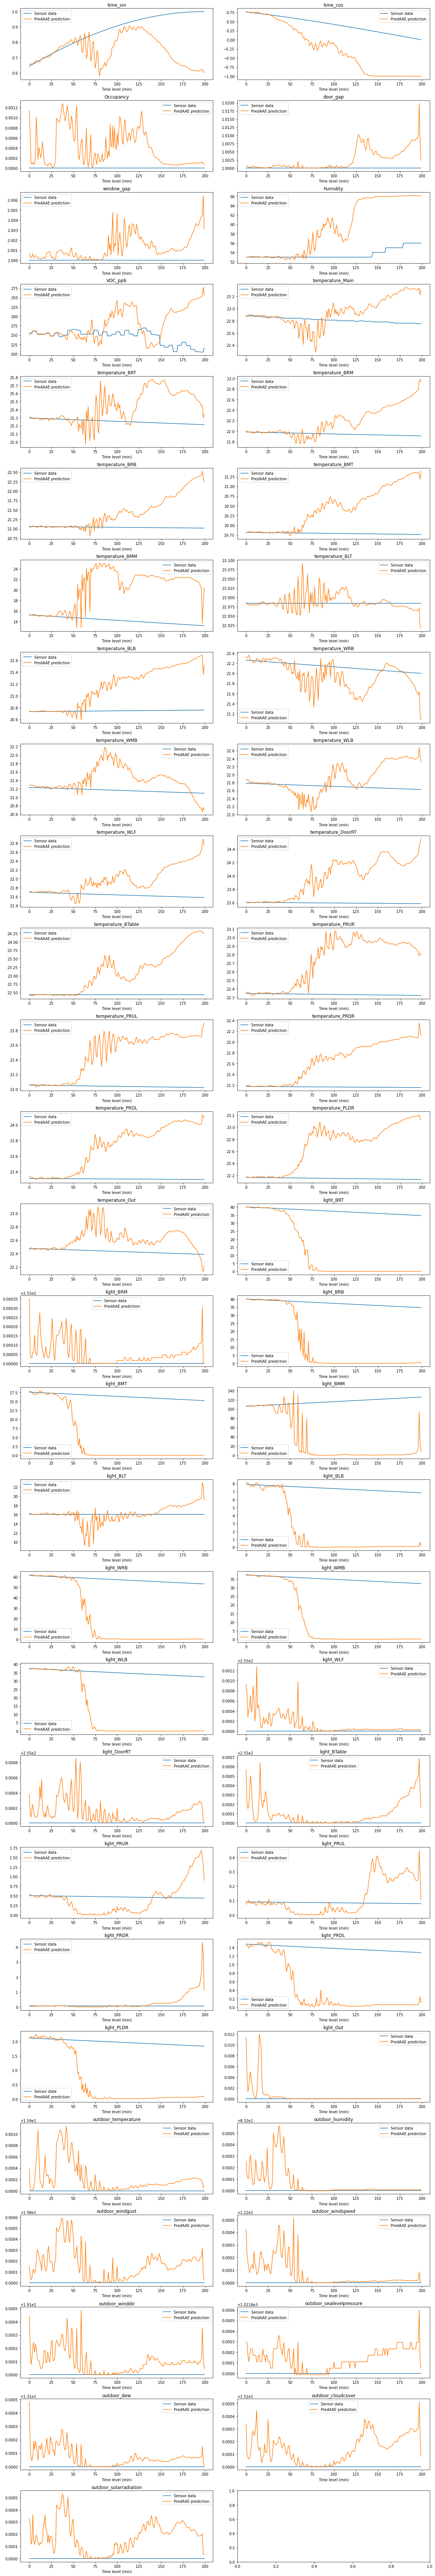

In [51]:
## show the first 200 time steps
fig, ax = plt.subplots(28,2, figsize=[16,24*4])  # figsize=[16,8]
fig.tight_layout(h_pad=3.5, w_pad=3.5)
for i in range(55):
    ax.flatten()[i].plot(range(0,200), all_values_scaledback[:200,i], '-')
    ax.flatten()[i].plot(range(0, 200), X_predict_scaledback [:200,i], '-')
    ax.flatten()[i].legend(['Sensor data', 'PredAAE prediction'])
    ax.flatten()[i].set_title(fields_list[i])
    ax.flatten()[i].set_xlabel('Time level (min)')